# Imports

In [2]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import os
from os import listdir
from os.path import isfile, join

import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Load datasets

In [3]:
datasets = list()
DATA_DIR = "../datasets/data"
TABULAR_SEP_FIX =  ["204", "205", "206", "207", "208", "225", "226", "242", "243"]

for dataset_filename in listdir(DATA_DIR):
    # 012_UCR_Anomaly_tiltAPB1_100000_114283_114350.txt
    # [0] [1] [2]     [3]      [4]    [5]    [6]   .txt
    split = dataset_filename.replace(".txt", "").split("_")
    
    dataset = {
        "number": split[0],
        "name": split[3],
        "train_end_idx": int(split[4]),
        "anomaly_start_idx": int(split[5]) - int(split[4]),
        "anomaly_end_idx": int(split[6]) - int(split[4]),
        "path": join(DATA_DIR, dataset_filename),
        "separator": "\n" if split[0] not in TABULAR_SEP_FIX else "  "
    }
    
    datasets.append(dataset)

In [4]:
def load_dataset(dataset):
    with open(dataset["path"]) as file:
        data_ = [float(x) for x in filter(None, file.read().split(dataset["separator"]))]
    return data_

In [5]:
for i in range(len(datasets)):
    data = load_dataset(datasets[i])
    datasets[i]["train"] = pd.Series(data[:datasets[i]["train_end_idx"]])
    datasets[i]["test"] = pd.Series(data[datasets[i]["train_end_idx"]:])

# Helper functions

In [6]:
def plot_dataset(dataset, figsize=(20,6)):
    d = dataset
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    
    fig.suptitle("Number: {} \n Name: {}".format(d["number"], d["name"]))
    
    # Plot test + train
    offset1 = np.array(range(len(d["test"]))) + len(d["train"])
    offset2 = np.array(range(d["anomaly_end_idx"] - d["anomaly_start_idx"])) + len(d["train"]) + d["anomaly_start_idx"]
    
    axs[0].plot(d["train"], color="palegreen")
    axs[0].plot(offset1, d["test"], color="skyblue")
    axs[0].plot(offset2, d["test"][d["anomaly_start_idx"]:d["anomaly_end_idx"]], color="red")
    
    axs[0].legend(["Train", "Test", "Anomaly"])
    
    # Show anonmaly
    
    
    offset3 = np.array(range(len(d["test"])+1000))
    
    axs[1].plot(d["test"][(d["anomaly_start_idx"]-1000):(d["anomaly_end_idx"]+1000)], color="lightblue")
    axs[1].plot(d["test"][(d["anomaly_start_idx"]):(d["anomaly_end_idx"])], color="red")
    

In [7]:
def threshold(data):
    radius = np.nanmax(data) - np.nanmin(data)
    threshold = np.nanmin(data) + 0.7 * radius
    return threshold

In [8]:
def plot_dataset_with_pred(dataset,y=None, figsize=(20,10)):
    d = dataset
    fig = plt.figure(figsize=figsize)
    
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])
    
    fig.suptitle("Number: {} \n Name: {}".format(d["number"], d["name"]))
    
    #fig2, axs2 = axs.subplots(2,1)
    # Plot test + train
    offset1 = np.array(range(len(d["test"]))) + len(d["train"])
    offset2 = np.array(range(d["anomaly_end_idx"] - d["anomaly_start_idx"])) + len(d["train"]) + d["anomaly_start_idx"]
    
    ax1.plot(d["train"], color="palegreen")
    ax1.plot(offset1, d["test"], color="skyblue")
    ax1.plot(offset2, d["test"][d["anomaly_start_idx"]:d["anomaly_end_idx"]], color="red")
    
    ax1.legend(["Train", "Test", "Anomaly"])
    
    # Show anonmaly
    offset3 = np.array(range(len(d["test"])+1000))
    
    ax2.plot(d["test"][(d["anomaly_start_idx"]-1000):(d["anomaly_end_idx"]+1000)], color="lightblue")
    ax2.plot(d["test"][(d["anomaly_start_idx"]):(d["anomaly_end_idx"])], color="red")
    ax2.set_title("Anomaly")
    ax2.legend(["Test", "Anomaly"])
    
    # Plot prediction score
    ax3.set_title("Reconstruction error on test data")
    ax3.plot(d["test"], color="skyblue")
    offset4 = np.array(range(d["anomaly_end_idx"]-(d["anomaly_start_idx"]))) + d["anomaly_start_idx"]
    ax3.plot(offset4,d["test"][(d["anomaly_start_idx"]):(d["anomaly_end_idx"])], color="red")
    ax3.legend(["test", "anomaly"])
    if y is not None:
        ax4 = ax3.twinx()
        ax4.plot(y, color="orange", alpha=0.7)
        ax4.legend(["recostruction error"], loc=2)
        
        th = threshold(y)
        ax4.plot([th] * len(y))

# Detect anomaly

In [9]:
from statsmodels.tsa.ar_model import AutoReg

In [11]:
data = datasets[61].copy()
d = data["train"].values.copy()
t = data["test"].values.copy()
mean = np.mean(d)
std = np.std(d)
t2 = (t - mean)/std

In [20]:
ar_model = AutoReg(t2, lags=4).fit()
y_pred = ar_model.predict(start=0, end=len(t2)-1, dynamic=False)*std + mean
error = np.power(np.abs(t-y_pred),2)

In [21]:
error

array([       nan,        nan,        nan, ..., 0.09960688, 0.13690586,
       0.00397358])

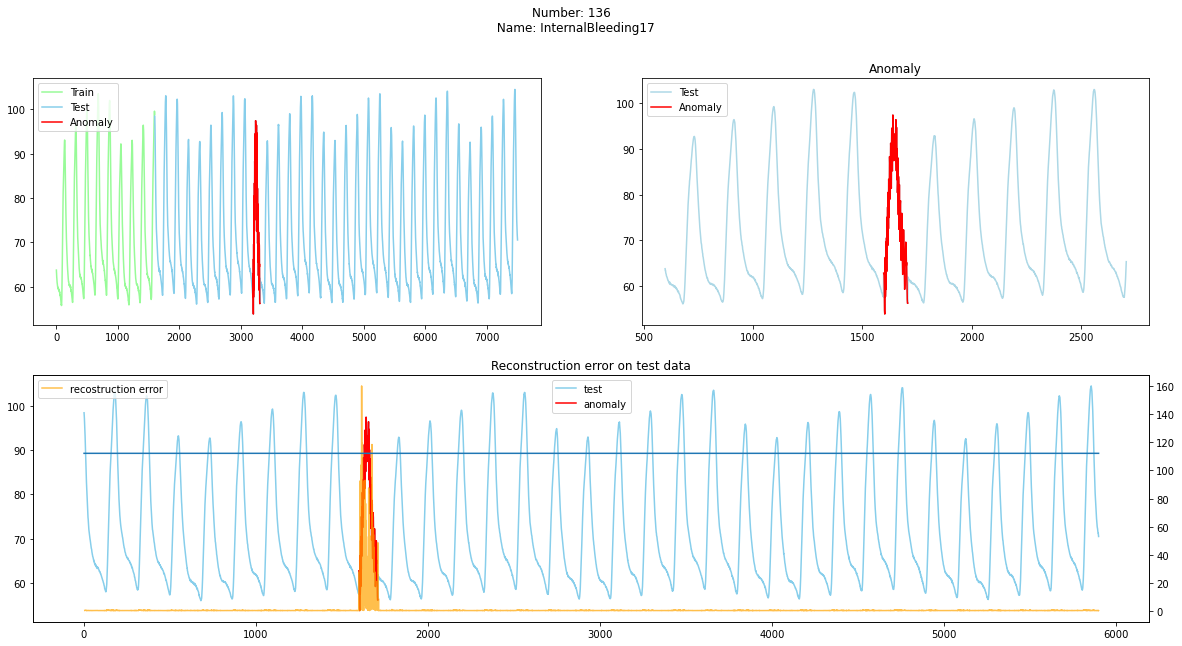

In [23]:
plot_dataset_with_pred(data, error)

In [28]:
def ar_detect(dataset, lags=4):
    data = datasets[61].copy()
    d = data["train"].values.copy()
    t = data["test"].values.copy()
    mean = np.mean(d)
    std = np.std(d)
    t2 = (t - mean)/std
    
    ar_model = AutoReg(t2, lags=4).fit()
    y_pred = ar_model.predict(start=0, end=len(t2)-1, dynamic=False)*std + mean
    error = np.power(np.abs(t-y_pred),2)
    return y_pred, error, ar_model.resid

In [29]:
ar_detect(datasets[61])

(array([        nan,         nan,         nan, ..., 70.95819443,
        71.18222791, 70.58915635]),
 array([       nan,        nan,        nan, ..., 0.09960688, 0.13690586,
        0.00397358]),
 array([-0.02101748, -0.02350122, -0.04081917, ...,  0.02424176,
        -0.02842043, -0.00484184]))

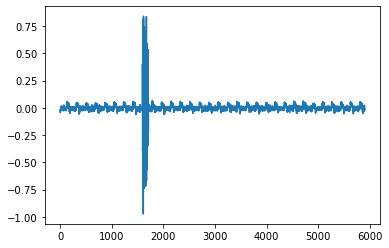

In [27]:
plt.plot(ar_model.resid)